## This movie dataset contains information about the top 1000 movies with most earnings in history. It has been webscraped from IMDB.
#### Source: https://www.imdb.com/list/ls098063263/
## The point of the notebook is to explore the part of the dataset which has to do with reviews. And also do sentiment analysis on the movie reviews

#### Imports for the notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation 
from ast import literal_eval
import plotly.express as px
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
stop_words = stopwords.words()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
#from sklearn.metrics import (classification_report )
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.metrics import confusion_matrix
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Janus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Janus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Janus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Cleaning dataset before exploring

In [2]:
df = pd.read_csv('../data/movies.csv')

df['reviews'] = df['reviews'].apply(literal_eval)
df['review_score'] = df['review_score'].apply(literal_eval)

reviews_list = df['reviews']
scores_list = df['review_score']

all_reviews = []
all_scores = []

for sublist in reviews_list:
    for review in sublist:
        all_reviews.append(review)
        
for sublist in scores_list:
    for score in sublist:
        all_scores.append(score)

df = pd.DataFrame({'reviews': all_reviews, 'scores': all_scores})

df = df[df['scores'] != 'No rating']

df

reviews scores
1      I was waiting for this day for the longest tim...  10/10
2      Nobody directs like James Cameron. Ten years i...   9/10
3      Forgive me, I'm going to jump from professiona...   8/10
4      Hatts of to JAMES CAMERON for thinking and cre...  10/10
5      I did see Avatar for the first time a while ag...   6/10
...                                                  ...    ...
24522  The key to The 40-Year-Old Virgin is not merel...   8/10
24523  A hilarious cast of characters and wonderfully...   6/10
24524  I'm not quite sure if the term "serious comedy...   8/10
24525  When it first came out I was 25, and for some ...   8/10
24526  I got a free pass to a preview of this movie l...  10/10

[22305 rows x 2 columns]

### Strip the score to single value and convert it to int

In [3]:
def extract_rating(rating_string):
    return int(rating_string.split('/')[0])

# apply the function to the rating column
df['scores'] = df['scores'].apply(extract_rating)

# print the updated dataframe
print(df)

                                                 reviews  scores
1      I was waiting for this day for the longest tim...      10
2      Nobody directs like James Cameron. Ten years i...       9
3      Forgive me, I'm going to jump from professiona...       8
4      Hatts of to JAMES CAMERON for thinking and cre...      10
5      I did see Avatar for the first time a while ag...       6
...                                                  ...     ...
24522  The key to The 40-Year-Old Virgin is not merel...       8
24523  A hilarious cast of characters and wonderfully...       6
24524  I'm not quite sure if the term "serious comedy...       8
24525  When it first came out I was 25, and for some ...       8
24526  I got a free pass to a preview of this movie l...      10

[22305 rows x 2 columns]


### Make a label column based of the scores of the movies. If the movie is rated 1-4 it will be labeled negative. 5-10 is labeled positive.

In [4]:
#Label the reviews positive and negative depending on their rating
def classify_rating(rating_string):
    rating = int(rating_string)
    if rating <= 4:
        return 'negative'
    else:
        return 'positive'

# apply the function to the rating column
df['label'] = df['scores'].apply(classify_rating)

## Exploring the data

In [5]:
# To show a few of each label.
negative_ratings = df[df['label'] == 'negative']
positive_ratings = df[df['label'] == 'positive']

print("Negative ratings:")
print(negative_ratings)

print("Positive ratings:")
print(positive_ratings)

Negative ratings:
                                                 reviews  scores     label
9      What a snooze fest.Did I watch a different mov...       1  negative
13     I really did not like the way way this movie w...       4  negative
16     The plot is stolen from many different movies,...       1  negative
38     Only a month or so back I was talking to a fri...       4  negative
49     I've just come from watching Endgame and I mus...       4  negative
...                                                  ...     ...       ...
24422  How is utter garbage like this allowed to make...       1  negative
24424  I really don't understand how people can enjoy...       1  negative
24426  What is this? Is this supposed to be a movie? ...       1  negative
24466  We don't go to see movies about dueling alien ...       4  negative
24475  If you give a toss about the story, stop readi...       2  negative

[3763 rows x 3 columns]
Positive ratings:
                                       

In [6]:
#Shows how many of each label
print("Shows how many reviews of each label")
df['label'].value_counts()

Shows how many reviews of each label


positive    18542
negative     3763
Name: label, dtype: int64

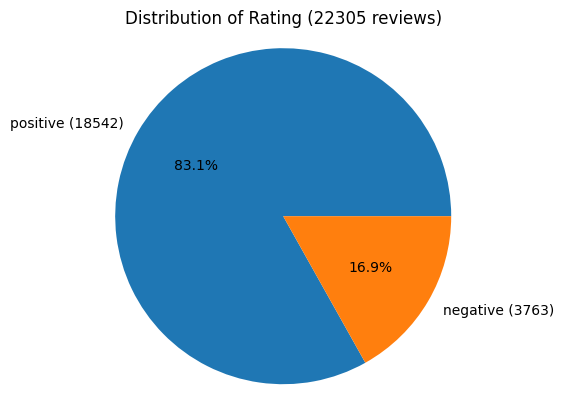

In [7]:
counts = df['label'].value_counts()

# Create a pie chart
plt.pie(counts, labels=[f'{label} ({count})' for label, count in zip(counts.index, counts)], autopct='%1.1f%%')

# Add a title and total count
plt.title('Distribution of Rating ({} reviews)'.format(sum(counts)))
plt.axis('equal')

plt.show()


### This Pie chart shows that we have 22305Reviews that are rated positive and negative. It is split 18542 Positive and 3763 Negative.
# 

C:\Users\Janus\AppData\Local\Temp\ipykernel_3652\2324180935.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = positive_reviews.append(negative_reviews)


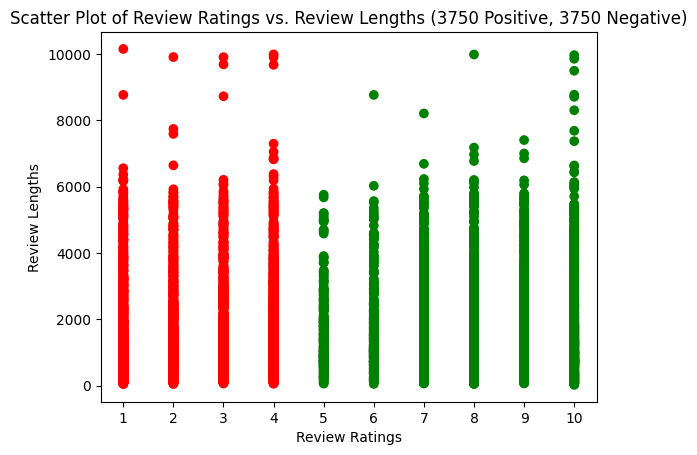

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Example data for sentiment (positive, negative)
sentiments = df['label']  

# Set a random seed for reproducibility
np.random.seed(42)

# Filter data for the same number of positive and negative reviews
positive_reviews = df[sentiments == 'positive'].sample(n=3750)
negative_reviews = df[sentiments == 'negative'].sample(n=3750)

# Combine the filtered positive and negative reviews
filtered_data = positive_reviews.append(negative_reviews)

# Extract the filtered movie ratings and review lengths
filtered_movie_ratings = filtered_data['scores']
filtered_review_lengths = filtered_data['reviews'].str.len()

# Create a list of colors based on sentiments (green for positive, red for negative)
colors = ['green' if label == 'positive' else 'red' for label in filtered_data['label']]

# Create the scatter plot
plt.scatter(filtered_movie_ratings, filtered_review_lengths, c=colors)

# Set x-axis ticks
plt.xticks(range(1, 11))

# Set labels and title
plt.xlabel('Review Ratings')
plt.ylabel('Review Lengths')
plt.title('Scatter Plot of Review Ratings vs. Review Lengths (3750 Positive, 3750 Negative)')

# Display the plot
plt.show()


####  This scatter plot displays negative reviews as red, and positive as green. 

#### It shows the correlation between the length of the reviews compared to the rating of the review

##### The points is to see if people put longer reviews if they dont like the movie or if they do like the movie

# 

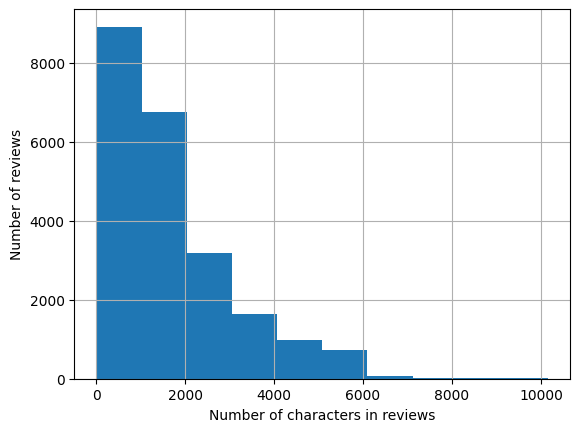

In [9]:
#A look at the number of characters present in each sentence. This can give us a rough idea about the movie's review.
df['reviews'].str.len().hist()
plt.xlabel('Number of characters in reviews')
plt.ylabel('Number of reviews')
plt.show()

### The histogram shows x-axis as the amount of characters in reviews and the y-axis as the amount of reviews.
##### Example first bar is roughly 8400 reviews that contains 0-1000 characters. And the second bar is 6300 reviews containing 2000 characters and so on.
# 
# 

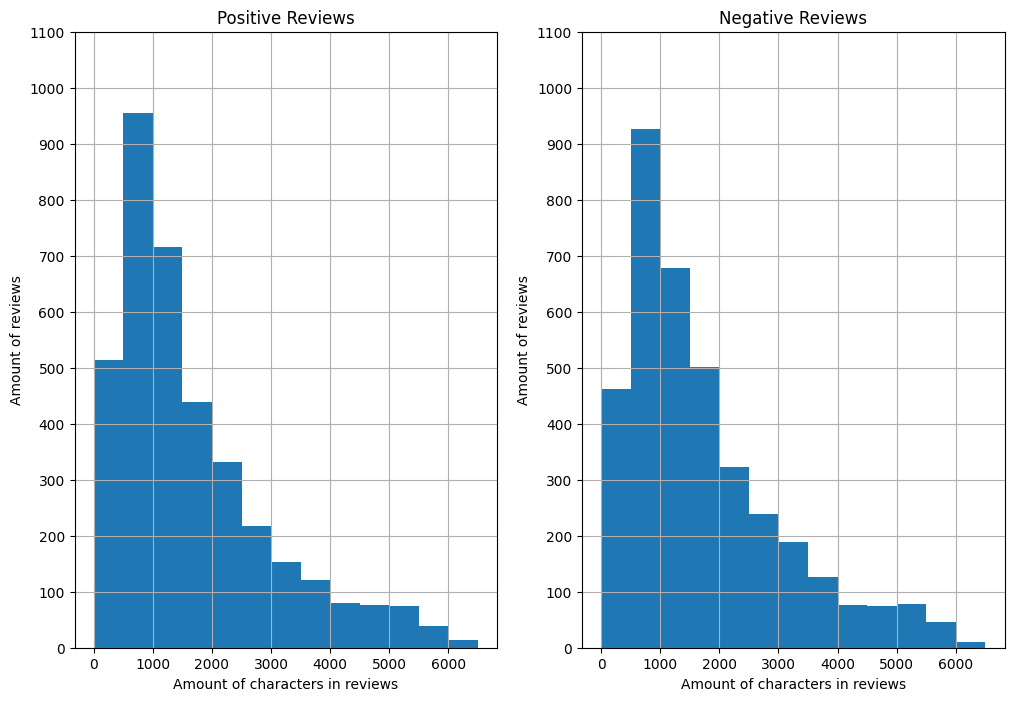

In [10]:
# Sample 6500 positive and negative reviews
num_reviews = 3750
positive_reviews = df[df['label'] == 'positive'].sample(n=num_reviews, random_state=42)
negative_reviews = df[df['label'] == 'negative'].sample(n=num_reviews, random_state=42)

# Set the bin size for the x-axis to 500
bins = np.arange(0, 7000, 500)
bins_y = np.arange(0, 1200, 100)

# Plot histograms of review lengths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.hist(positive_reviews['reviews'].str.len(), bins=bins)
ax1.set_title('Positive Reviews')
ax1.set_ylabel('Amount of reviews')
ax1.set_xlabel('Amount of characters in reviews')
ax1.grid(True)
ax1.set_yticks(bins_y)

ax2.hist(negative_reviews['reviews'].str.len(), bins=bins)
ax2.set_title('Negative Reviews')
ax2.set_ylabel('Amount of reviews')
ax2.set_xlabel('Amount of characters in reviews')
ax2.grid(True)
ax2.set_yticks(bins_y)
plt.show()

### A Histogram to show the amount of reviews and the amount of characters in the reviews in positive and negative reviews
### In general people leave equally long reviews for positive and negative reviews but in some cases there is a small difference
# 
# 

### Wordcloud graphs to show the most used words in large font and the least used words in small font in positive review and negative review

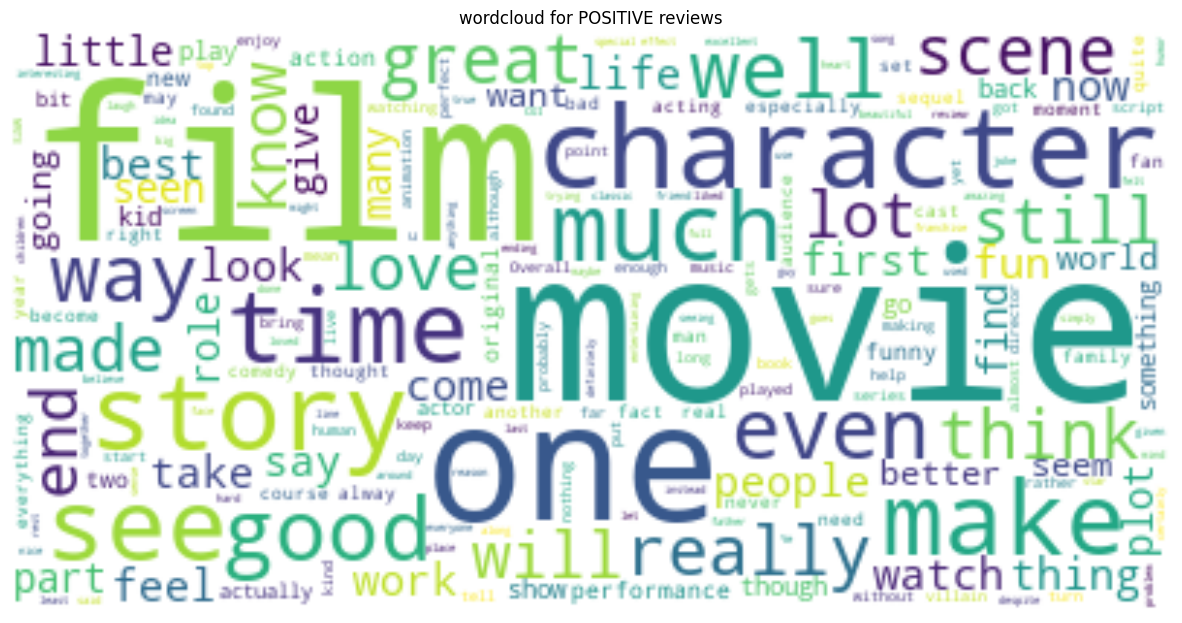

In [11]:
text = " ".join(i for i in df[df['label']=='positive']['reviews'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for POSITIVE reviews')
plt.show()

### And for negative reviews

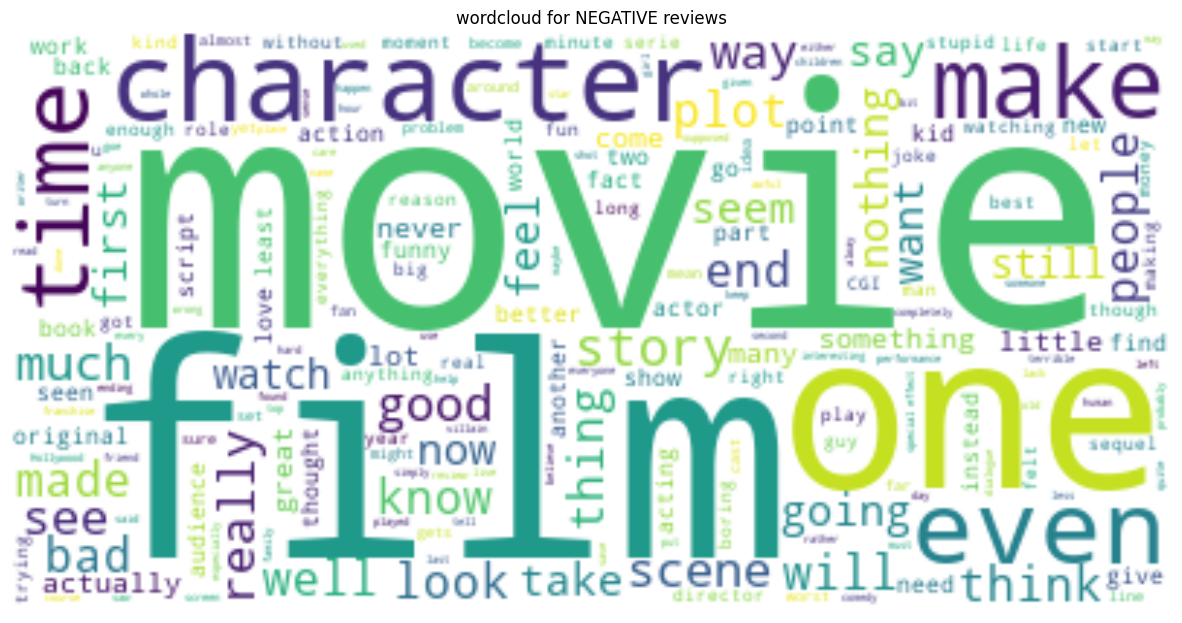

In [12]:
text = " ".join(i for i in df[df['label']=='negative']['reviews'])
#stopwords = set(STOPWORDS)
wordcloud = WordCloud( background_color="white").generate(text)
#wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for NEGATIVE reviews')
plt.show()

### The wordcloud graphs in both negative and postitive comments don't tell you much.

### That's is the reason why text preprosessing is useful.

# Preprocessing - Clean the data text reviews

In [13]:
df.rename(columns={'reviews':'text'}, inplace = True)
df.rename(columns={'label':'sentiment'}, inplace = True)
df

text  scores sentiment
1      I was waiting for this day for the longest tim...      10  positive
2      Nobody directs like James Cameron. Ten years i...       9  positive
3      Forgive me, I'm going to jump from professiona...       8  positive
4      Hatts of to JAMES CAMERON for thinking and cre...      10  positive
5      I did see Avatar for the first time a while ag...       6  positive
...                                                  ...     ...       ...
24522  The key to The 40-Year-Old Virgin is not merel...       8  positive
24523  A hilarious cast of characters and wonderfully...       6  positive
24524  I'm not quite sure if the term "serious comedy...       8  positive
24525  When it first came out I was 25, and for some ...       8  positive
24526  I got a free pass to a preview of this movie l...      10  positive

[22305 rows x 3 columns]

In [14]:
def cleaning(text):        
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower() # converting to lowercase
    text = re.sub('https?://\S+|www\.\S+', '', text) # removing URL links
    text = re.sub(r"\b\d+\b", "", text) # removing number 
    text = re.sub('<.*?>+', '', text) # removing special characters, 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # punctuations
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
   
    #removing emoji: 
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)   

   # removing short form: 
    
    text=re.sub("isn't",'is not',text)
    text=re.sub("wasn't",'was not',text)
    text=re.sub("there's",'there is',text)
    text=re.sub("couldn't",'could not',text)
    text=re.sub("won't",'will not',text)
    text=re.sub("they're",'they are',text)
    text=re.sub("she's",'she is',text)
    text=re.sub("There's",'there is',text)
    text=re.sub("wouldn't",'would not',text)
    text=re.sub("haven't",'have not',text)
    text=re.sub("That's",'That is',text)
    text=re.sub("you've",'you have',text)
    text=re.sub("He's",'He is',text)
    text=re.sub("what's",'what is',text)
    text=re.sub("weren't",'were not',text)
    text=re.sub("we're",'we are',text)
    text=re.sub("hasn't",'has not',text)
    text=re.sub("you'd",'you would',text)
    text=re.sub("shouldn't",'should not',text)
    text=re.sub("let's",'let us',text)
    text=re.sub("they've",'they have',text)
    text=re.sub("You'll",'You will',text)
    text=re.sub("i'm",'i am',text)
    text=re.sub("we've",'we have',text)
    text=re.sub("it's",'it is',text)
    text=re.sub("don't",'do not',text)
    text=re.sub("that´s",'that is',text)
    text=re.sub("I´m",'I am',text)
    text=re.sub("it’s",'it is',text)
    text=re.sub("she´s",'she is',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('I’m','I am',text)
    text=re.sub('I’d','I did',text)
    text=re.sub("hes'",'he is',text)
    text=re.sub('there’s','there is',text)
    
     
    return text
    
dt = df['text'].apply(cleaning)

In [15]:
dt = pd.DataFrame(dt)  
dt['sentiment']=df['sentiment']
dt

text sentiment
1      i was waiting for this day for the longest tim...  positive
2      nobody directs like james cameron ten years in...  positive
3      forgive me im going to jump from professional ...  positive
4      hatts of to james cameron for thinking and cre...  positive
5      i did see avatar for the first time a while ag...  positive
...                                                  ...       ...
24522  the key to the yearold virgin is not merely th...  positive
24523  a hilarious cast of characters and wonderfully...  positive
24524  im not quite sure if the term serious comedy a...  positive
24525  when it first came out i was  and for some rea...  positive
24526  i got a free pass to a preview of this movie l...  positive

[22305 rows x 2 columns]

In [16]:
# Remove stop words - Examples of stop words in English include "the," "and," "of," and "in."
dt['no_sw'] = dt['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [17]:
dt

text sentiment  \
1      i was waiting for this day for the longest tim...  positive   
2      nobody directs like james cameron ten years in...  positive   
3      forgive me im going to jump from professional ...  positive   
4      hatts of to james cameron for thinking and cre...  positive   
5      i did see avatar for the first time a while ag...  positive   
...                                                  ...       ...   
24522  the key to the yearold virgin is not merely th...  positive   
24523  a hilarious cast of characters and wonderfully...  positive   
24524  im not quite sure if the term serious comedy a...  positive   
24525  when it first came out i was  and for some rea...  positive   
24526  i got a free pass to a preview of this movie l...  positive   

                                                   no_sw  
1      waiting day longest time kid back movie releas...  
2      directs james cameron ten years works minute w...  
3      forgive jump professional boy jitters film ive...  
4      hatts james cameron creating vision takes lots...  
5      avatar time ago make felt visual feast rewatch...  
...                                                  ...  
24522  key yearold virgin andy stitzer yearold virgin...  
24523  hilarious cast characters wonderfully talented...  
24524  term comedy applies movie applied years movie ...  
24525  reason hated nose stuck air account popularim ...  
24526  free pass preview movie night expect premise s...  

[22305 rows x 3 columns]

# Display the 10 most frequent used words

In [18]:
#Display the 10 most Frequent Words: 
from collections import Counter
cnt = Counter()
for text in dt["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp

word  count
0       movie  47860
1        film  45656
2       story  16834
3        time  14063
4       great  13844
5  characters  11790
6      action  11748
7   character  10555
8       films  10182
9      movies   9680

###### Displays the 10 most frequent words

In [19]:
px.bar(temp, x="count", y="word", title='Commmon Words in Text', orientation='h', 
             width=700, height=700)

## removing the most frequent words from the text

#### The purpose of removing the most frequent words is to reduce the impact of common words on the analysis. Often, these words are not very informative in distinguishing between different documents or texts, and removing them can improve the accuracy of text analysis and machine learning models.

In [20]:
# Remove the most frequent words:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
dt["wo_stopfreq"] = dt["no_sw"].apply(lambda text: remove_freqwords(text))
dt.head()

text sentiment  \
1  i was waiting for this day for the longest tim...  positive   
2  nobody directs like james cameron ten years in...  positive   
3  forgive me im going to jump from professional ...  positive   
4  hatts of to james cameron for thinking and cre...  positive   
5  i did see avatar for the first time a while ag...  positive   

                                               no_sw  \
1  waiting day longest time kid back movie releas...   
2  directs james cameron ten years works minute w...   
3  forgive jump professional boy jitters film ive...   
4  hatts james cameron creating vision takes lots...   
5  avatar time ago make felt visual feast rewatch...   

                                         wo_stopfreq  
1  waiting day longest kid back released watch ba...  
2  directs james cameron ten years works minute w...  
3  forgive jump professional boy jitters ive avat...  
4  hatts james cameron creating vision takes lots...  
5  avatar ago make felt visual feast rewatching f...

##### no_sw = no stopwords. 
##### wo_stopfreq = remove 10 most common words in no_sw. 

# 
## Two examples to show the difference after removing the 10 most frequent words

In [21]:
dt['no_sw'].loc[5]

'avatar time ago make felt visual feast rewatching found strengths weaknesses prevent masterpiecestarting avatars strengths absolutely mindblowing visually cinematography landscapes scenery colours makeup effects outstanding away avatars strongest asset score score heard nice moments camerons direction competent message admirable finale explosive loved flying sequences breathtakingthe acting general mixed bag sam worthington charismatic lead zoe saldana strong spirited stephen lang enjoyable overthetop villain piece sigourney weaver soso character interesting michelle rodriguez joel moore dowhat work avatars story themes love time chaos hostile environment simplistic predictable felt relationship jake neytiri dull side film drag times particularly wrong concept original heard described dances wolves space ripoffs pocahontas ferngully join admit originality lack concept intrigued dialogue special rings amusing moments vast majority dialogue middle film convinced cheesy characters cliché

In [22]:
dt['wo_stopfreq'].loc[5]

'avatar ago make felt visual feast rewatching found strengths weaknesses prevent masterpiecestarting avatars strengths absolutely mindblowing visually cinematography landscapes scenery colours makeup effects outstanding away avatars strongest asset score score heard nice moments camerons direction competent message admirable finale explosive loved flying sequences breathtakingthe acting general mixed bag sam worthington charismatic lead zoe saldana strong spirited stephen lang enjoyable overthetop villain piece sigourney weaver soso interesting michelle rodriguez joel moore dowhat work avatars themes love chaos hostile environment simplistic predictable felt relationship jake neytiri dull side drag times particularly wrong concept original heard described dances wolves space ripoffs pocahontas ferngully join admit originality lack concept intrigued dialogue special rings amusing moments vast majority dialogue middle convinced cheesy clichéd especially giovanni ribisis development lacki

# 
#### Lemmatization: Lemmatization is converting the word to its base form or lemma by removing affixes from the inflected words. 
#### It helps to create better features for machine learning and NLP models hence it is an important preprocessing step.

In [23]:
wordnet_lem = WordNetLemmatizer()

dt['wo_stopfreq_lem'] = dt['wo_stopfreq'].apply(wordnet_lem.lemmatize)
dt

text sentiment  \
1      i was waiting for this day for the longest tim...  positive   
2      nobody directs like james cameron ten years in...  positive   
3      forgive me im going to jump from professional ...  positive   
4      hatts of to james cameron for thinking and cre...  positive   
5      i did see avatar for the first time a while ag...  positive   
...                                                  ...       ...   
24522  the key to the yearold virgin is not merely th...  positive   
24523  a hilarious cast of characters and wonderfully...  positive   
24524  im not quite sure if the term serious comedy a...  positive   
24525  when it first came out i was  and for some rea...  positive   
24526  i got a free pass to a preview of this movie l...  positive   

                                                   no_sw  \
1      waiting day longest time kid back movie releas...   
2      directs james cameron ten years works minute w...   
3      forgive jump professional boy jitters film ive...   
4      hatts james cameron creating vision takes lots...   
5      avatar time ago make felt visual feast rewatch...   
...                                                  ...   
24522  key yearold virgin andy stitzer yearold virgin...   
24523  hilarious cast characters wonderfully talented...   
24524  term comedy applies movie applied years movie ...   
24525  reason hated nose stuck air account popularim ...   
24526  free pass preview movie night expect premise s...   

                                             wo_stopfreq  \
1      waiting day longest kid back released watch ba...   
2      directs james cameron ten years works minute w...   
3      forgive jump professional boy jitters ive avat...   
4      hatts james cameron creating vision takes lots...   
5      avatar ago make felt visual feast rewatching f...   
...                                                  ...   
24522  key yearold virgin andy stitzer yearold virgin...   
24523  hilarious cast wonderfully talented comedians ...   
24524  term comedy applies applied years theaters fil...   
24525  reason hated nose stuck air account popularim ...   
24526  free pass preview night expect premise silly a...   

                                         wo_stopfreq_lem  
1      waiting day longest kid back released watch ba...  
2      directs james cameron ten years works minute w...  
3      forgive jump professional boy jitters ive avat...  
4      hatts james cameron creating vision takes lots...  
5      avatar ago make felt visual feast rewatching f...  
...                                                  ...  
24522  key yearold virgin andy stitzer yearold virgin...  
24523  hilarious cast wonderfully talented comedians ...  
24524  term comedy applies applied years theaters fil...  
24525  reason hated nose stuck air account popularim ...  
24526  free pass preview night expect premise silly a...  

[22305 rows x 5 columns]

##### no_sw = no stopwords. 
##### wo_stopfreq = remove 10 most common words in no_sw. 
##### wo_stopfreq_lem = lemmatization of wo_stopfreq.

# 
# 

# Tokenization

In [24]:
# create the cleaned data for the train-test split:
nb=dt.drop(columns=['text','no_sw', 'wo_stopfreq'])
nb.columns=['sentiment','review']
nb.sentiment = [0 if each == "negative" else 1 for each in nb.sentiment]
nb

sentiment                                             review
1              1  waiting day longest kid back released watch ba...
2              1  directs james cameron ten years works minute w...
3              1  forgive jump professional boy jitters ive avat...
4              1  hatts james cameron creating vision takes lots...
5              1  avatar ago make felt visual feast rewatching f...
...          ...                                                ...
24522          1  key yearold virgin andy stitzer yearold virgin...
24523          1  hilarious cast wonderfully talented comedians ...
24524          1  term comedy applies applied years theaters fil...
24525          1  reason hated nose stuck air account popularim ...
24526          1  free pass preview night expect premise silly a...

[22305 rows x 2 columns]

In [25]:
tokenized_review=nb['review'].apply(lambda x: x.split())
tokenized_review.head(5)

1    [waiting, day, longest, kid, back, released, w...
2    [directs, james, cameron, ten, years, works, m...
3    [forgive, jump, professional, boy, jitters, iv...
4    [hatts, james, cameron, creating, vision, take...
5    [avatar, ago, make, felt, visual, feast, rewat...
Name: review, dtype: object

In [26]:
warnings.filterwarnings('ignore')

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(nb['review'])

### Train-test Split:

##### The test_size parameter is set to 0.20, meaning that 20% of the data will be used for testing, and the remaining 80% will be used for training.
##### The random_state parameter is set to 30, which ensures that the same random samples are selected every time the code is run.

In [27]:
X=text_counts
y=nb['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=30)

#### We will now split the data for training and testing to check how well our model has performed.

#### Also we will randomize the data in case our data includes all positive first and then all negative or some other kind of bias.
# 
# 

# Naive Bayes Modelling:


### Multinomial Naive Bayes (MNB) Model:


###### The Multinomial Naive Bayes model is a variation of the Naive Bayes algorithm that works well with text data. It is commonly used in document classification, where the occurrence of words in a document is used to predict the class of the document. In MNB, each document is represented as a bag of words, and the frequency of each word is used to estimate the probability of a particular class. MNB assumes that the occurrence of each word is independent of each other.

In [28]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

MultinominalNB model accuracy is 88.57%
------------------------------------------------
Confusion Matrix:
     0     1
0  330   392
1  118  3621
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.46      0.56       722
           1       0.90      0.97      0.93      3739

    accuracy                           0.89      4461
   macro avg       0.82      0.71      0.75      4461
weighted avg       0.88      0.89      0.87      4461



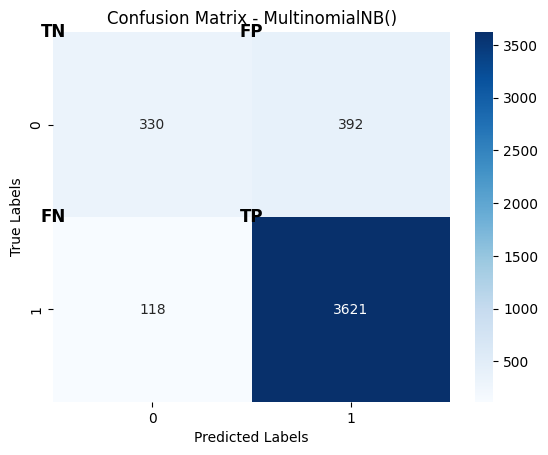

In [29]:
warnings.filterwarnings("ignore")

k = [MNB]  
for i in k:
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predicted)

    # Create a heatmap for the confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - {}'.format(i))

    # Add labels to heatmap cells
    ax = plt.gca()
    ax.text(0, 0, 'TN', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
    ax.text(1, 0, 'FP', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
    ax.text(0, 1, 'FN', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
    ax.text(1, 1, 'TP', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

    plt.show()

### Save the model in order to use it for our frontend solution.

In [30]:
import pickle

# save the model using pickle
with open("../server/pre_trained_models/naive_bayes_model.pkl", "wb") as f:
    pickle.dump(MNB, f)
with open('../server/pre_trained_models/count_vec.pkl', 'wb') as f:
    pickle.dump(cv, f)

### Use the model on a text string (review)

In [31]:
def predict_sentiment(text, cv, model):
    # Transform the text into a bag-of-words representation
    text_counts = cv.transform([text])
    
    # Use the trained model to predict the sentiment of the text
    predicted_sentiment = model.predict(text_counts)
    
    # Convert the predicted sentiment to a string ("Positive" or "Negative")
    if predicted_sentiment == 1:
        return "Positive"
    else:
        return "Negative"

##### A positive review

In [32]:
positive_review_text = "This is a really good movie i  like the plot. It is very well made."
predicted_sentiment = predict_sentiment(positive_review_text, cv, MNB)
print("Predicted sentiment for text: ", predicted_sentiment)

Predicted sentiment for text:  Positive


##### A negative review

In [33]:
negative_review_text = "This is a really bad movie i don't like the plot. It is poorly made."
predicted_sentiment = predict_sentiment(negative_review_text, cv, MNB)
print("Predicted sentiment for text: ", predicted_sentiment)

Predicted sentiment for text:  Negative


# Using the model on all the reviews we have scraped and compare it to the labeled

## We want to clean the data so it is the same as the one we were exploring earlier in the notebook in order to make a better comparison 1:1

In [34]:
new_df = pd.read_csv('../data/movies.csv')

In [35]:
new_df['reviews'] = new_df['reviews'].apply(literal_eval)
new_df['review_score'] = new_df['review_score'].apply(literal_eval)

new_reviews_list = new_df['reviews']
new_scores_list = new_df['review_score']

new_all_reviews = []
new_all_scores = []

for sublist in new_reviews_list:
    for review in sublist:
        new_all_reviews.append(review)
        
for sublist in new_scores_list:
    for score in sublist:
        new_all_scores.append(score)

new_df = pd.DataFrame({'reviews': new_all_reviews, 'scores': new_all_scores})

new_df = new_df[new_df['scores'] != 'No rating']

In [36]:
def extract_rating(rating_string):
    return int(rating_string.split('/')[0])

# apply the function to the rating column
new_df['scores'] = new_df['scores'].apply(extract_rating)

In [37]:
def classify_rating(rating_string):
    rating = int(rating_string)
    if rating <= 4:
        return 'negative'
    else:
        return 'positive'

# apply the function to the rating column
new_df['label'] = new_df['scores'].apply(classify_rating)

# Apply the model to all of my reviews

In [38]:
# Apply the predict_sentiment function to each review and create a new column for the predicted labels
new_df['predicted_label'] = new_df['reviews'].apply(lambda x: predict_sentiment(x, cv, MNB))

#### Remove scores as it is unecessary information

In [39]:
new_df = new_df[['reviews', 'label', 'predicted_label']]
new_df

reviews     label  \
1      I was waiting for this day for the longest tim...  positive   
2      Nobody directs like James Cameron. Ten years i...  positive   
3      Forgive me, I'm going to jump from professiona...  positive   
4      Hatts of to JAMES CAMERON for thinking and cre...  positive   
5      I did see Avatar for the first time a while ag...  positive   
...                                                  ...       ...   
24522  The key to The 40-Year-Old Virgin is not merel...  positive   
24523  A hilarious cast of characters and wonderfully...  positive   
24524  I'm not quite sure if the term "serious comedy...  positive   
24525  When it first came out I was 25, and for some ...  positive   
24526  I got a free pass to a preview of this movie l...  positive   

      predicted_label  
1            Positive  
2            Positive  
3            Positive  
4            Positive  
5            Positive  
...               ...  
24522        Positive  
24523        Positive  
24524        Positive  
24525        Positive  
24526        Positive  

[22305 rows x 3 columns]

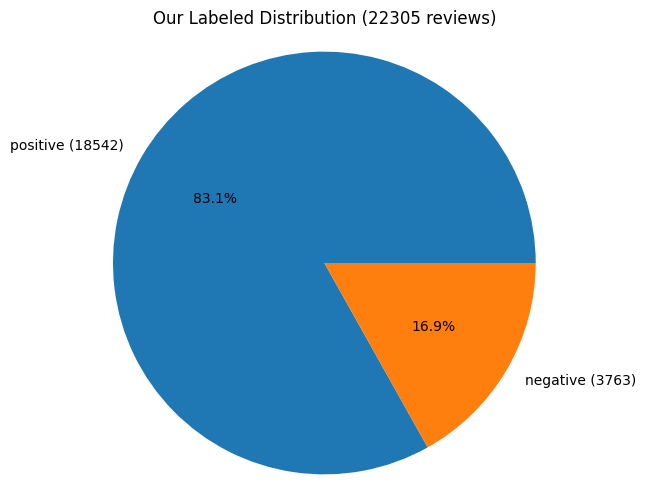

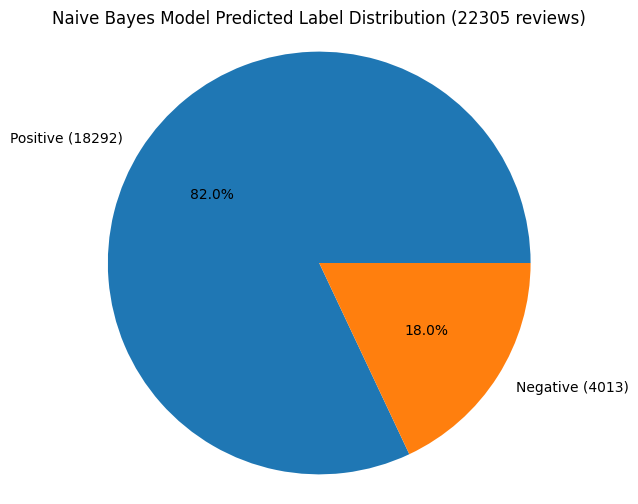

In [40]:
# Count the occurrences of each sentiment and new_predicted_label
sentiment_counts = new_df['label'].value_counts()
predicted_label_counts = new_df['predicted_label'].value_counts()

# Create pie chart for 'sentiment' column
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=[f'{label} ({count})' for label, count in zip(sentiment_counts.index, sentiment_counts)], autopct='%1.1f%%')
plt.title('Our Labeled Distribution ({} reviews)'.format(sum(sentiment_counts)))
plt.axis('equal')
plt.show()

# Create pie chart for 'new_predicted_label' column
plt.figure(figsize=(6, 6))
plt.pie(predicted_label_counts, labels=[f'{label} ({count})' for label, count in zip(predicted_label_counts.index, predicted_label_counts)], autopct='%1.1f%%')
plt.title('Naive Bayes Model Predicted Label Distribution ({} reviews)'.format(sum(predicted_label_counts)))
plt.axis('equal')
plt.show()


# Comparison between positive and negative. The first piechart is our own added labels and the second one is the model used on our reviews from our dataset